In [1]:
!git clone https://github.com/Kaleb-Huneau/GAN-Group6.git

fatal: destination path 'GAN-Group6' already exists and is not an empty directory.


Preprocessing: for the brain MRI dataset [Brain tumor MRI](https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py)


In [2]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import imutils
from PIL import Image
import matplotlib.pyplot as plt

def make_directory(PATH):
	if not os.path.exists(PATH):
		os.mkdir(PATH)

def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img


if __name__ == "__main__":
	training = 'GAN-Group6/Dataset/Training'
	testing = 'GAN-Group6/Dataset/Testing'

	make_directory(training)
	make_directory(testing)

	IMG_SIZE = 128

	# Now, list the directories after creating them
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	tumors = ["glioma", "meningioma", "notumor", "pituitary"]

	for dir in tumors:
			save_path = 'cleaned4/Training/' + dir
			path = os.path.join(training, dir)
			image_dir = os.listdir(path)
			for img in image_dir:
					image = cv2.imread(os.path.join(path, img))
					new_img = crop_img(image)
					new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
					new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
					if not os.path.exists(save_path):
							os.makedirs(save_path)
					cv2.imwrite(os.path.join(save_path, img), new_img)
     
	for dir in tumors:
			save_path = 'cleaned4/Testing/' + dir
			path = os.path.join(testing, dir)
			image_dir = os.listdir(path)
			for img in image_dir:
					image = cv2.imread(os.path.join(path, img))
					new_img = crop_img(image)
					new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
					new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
					if not os.path.exists(save_path):
							os.makedirs(save_path)
					cv2.imwrite(os.path.join(save_path, img), new_img)

ModuleNotFoundError: No module named 'cv2'

GAN

In [ ]:
import os
import time
import tensorflow as tf
#import tensorflow_probability as tfp
from keras.initializers import RandomNormal
from keras import Sequential
from keras.layers import Dense, BatchNormalization, \
    LeakyReLU, Conv2DTranspose, Conv2D, Dropout, \
        Flatten, Reshape, ReLU, Input, Concatenate
from keras import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.layers import Activation
from tensorflow.python.data import Iterator
import numpy as np
import pandas as pd
import scipy as sp
import sys
import multiprocessing
import argparse
import matplotlib.pyplot as plt
#import stacked_mnist

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
IMG_SIZE = 128

#tfd = tfp.distributions

def make_directory(PATH):
    if not os.path.exists(PATH):
            os.mkdir(PATH)


class AlphaGAN(object):
    def __init__(self, opt):
        self.opt = opt
        self.batch_size = 1
        self.noise_dim = 128*128
        self.epsilon = 1e-8
        self.alpha_d = float(opt.alpha_d)
        self.alpha_g = float(opt.alpha_g)
        self.seed = opt.seed
        self.loss_type = opt.loss_type
        self.dataset = opt.dataset
        self.n_epochs = opt.n_epochs
        self.gp = opt.gp
        self.scores = np.zeros(self.n_epochs)
        self.num_images = opt.num_images
        self.gp_coef = opt.gp_coef
        if self.dataset != 'cifar10':
            self.num_images = 10
        self.d_opt = Adam(2e-4, beta_1 = 0.5)
        self.g_opt = Adam(2e-4, beta_1 = 0.5)
        if self.dataset == 'cifar10':
            self.noise_dim = 100
        self.l1 = opt.l1
        tf.random.set_seed(self.seed)
        np.random.seed(self.seed)


    def get_data(self):
        if self.dataset == 'mnist':
            (self.train_img, _), (self.test_img, _) = tf.keras.datasets.mnist.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 28, 28, 1)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 28, 28, 1)

        elif self.dataset == 'cifar10':
            (self.train_img, _), (self.test_img, _) = tf.keras.datasets.cifar10.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 32, 32, 3)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 32, 32, 3)

        elif self.dataset == 'stacked-mnist':
            (self.train_img, _), (self.test_img, _) = stacked_mnist.load_data()
            self.train_img = self.train_img.reshape(self.train_img.shape[0], 32, 32, 3)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], 32, 32, 3)

        elif self.dataset == 'mri':
            # Iterate over all files in the tumor directory

            tumor_dir = '/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/v5/cleaned4/Training/notumor'
            tumor_training_images = []
            for filename in os.listdir(tumor_dir):
                if filename.endswith('.jpg'):  # Assuming images are in JPG format
                    image_path = os.path.join(tumor_dir, filename)
                    image = plt.imread(image_path, format='jpg')
                    tumor_training_images.append(image)

            # Convert the list of images to a NumPy array
            self.train_img = np.asarray(tumor_training_images)

            tumor_dir = '/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/v5/cleaned4/Testing/notumor'
            tumor_testing_images = []
            for filename in os.listdir(tumor_dir):
                if filename.endswith('.jpg'):  # Assuming images are in JPG format
                    image_path = os.path.join(tumor_dir, filename)
                    image = plt.imread(image_path, format='jpg')
                    tumor_testing_images.append(image)

            # Convert the list of images to a NumPy array
            self.test_img = np.asarray(tumor_testing_images)

            self.train_img = self.train_img.reshape(self.train_img.shape[0], IMG_SIZE, IMG_SIZE, 1)
            self.test_img = self.test_img.reshape(self.test_img.shape[0], IMG_SIZE, IMG_SIZE, 1)

          # self.train_img =  np.asarray([plt.imread("cleaned4/Training/notumor/Tr-noTr_0000.jpg", format='jpg')])
          # self.test_img = np.asarray([plt.imread("cleaned4/Testing/notumor/Te-noTr_0000.jpg", format='jpg')])

        self.real_mu, self.real_sigma = self.get_eval_metrics(self.train_img)
        self.train_data, self.test_data = self.clean_data(self.train_img, train = True), self.clean_data(self.test_img, train = False)


    def get_eval_metrics(self, data):
        img_dims = data.shape
        eval_img = data[np.random.choice(img_dims[0], 1, replace=False), :, :, :]
        eval_img = eval_img.reshape(1, np.prod(img_dims[1:])).astype('float32') # CHANGE BACK TO 10000
        eval_img = eval_img / 255.0
        real_mu = eval_img.mean(axis = 0)
        eval_img = np.transpose(eval_img)
        real_sigma = np.cov(eval_img)
        return real_mu, real_sigma

    def clean_data(self, data, train):

        new_data = data.astype('float32')
        new_data = (new_data - 127.5) / 127.5
        if train:
            new_data = tf.data.Dataset.from_tensor_slices(new_data)
            return new_data.shuffle(100000).batch(self.batch_size)
        return new_data

    def gen_loss_vanilla(self):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)
        loss_expr =  bce(tf.ones_like(self.fake_predicted_labels), self.fake_predicted_labels)
        if self.l1:
            loss_expr = tf.math.abs(loss_expr - (-tf.math.log(2.0)))
        return loss_expr

    def gen_loss_vanilla_l1(self):
        return tf.math.abs(self.gen_loss_vanilla() - (-tf.math.log(2.0)))


    def gen_loss_alpha(self):
        fake_expr = tf.math.pow(1 - self.fake_predicted_labels, ((self.alpha_g-1)/self.alpha_g)*tf.ones_like(self.fake_predicted_labels))
        fake_loss = tf.math.reduce_mean(fake_expr)
        loss_expr = (self.alpha_g/(self.alpha_g - 1))*(fake_loss - 2.0)
        if self.l1:
            equil_val = (self.alpha_g)/(self.alpha_g - 1)*(tf.math.pow(2.0, 1/self.alpha_g) - 2)
            loss_expr = tf.math.abs(loss_expr - equil_val)
        return loss_expr

    def dis_loss_vanilla(self):
        bce = tf.keras.losses.BinaryCrossentropy(from_logits = False)
        real_loss = bce(tf.ones_like(self.real_predicted_labels), self.real_predicted_labels)
        fake_loss = bce(tf.zeros_like(self.fake_predicted_labels), self.fake_predicted_labels)
        r1_penalty = 0
        if self.gp:
            gradients = tf.gradients(-tf.math.log(1 / self.real_predicted_labels - 1), [self.img])[0]
            r1_penalty = tf.reduce_mean(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        return real_loss + fake_loss + self.gp_coef*r1_penalty

    def dis_loss_alpha(self):
        real_expr = tf.math.pow(self.real_predicted_labels, ((self.alpha_d-1)/self.alpha_d)*tf.ones_like(self.real_predicted_labels))
        real_loss = tf.math.reduce_mean(real_expr)
        fake_expr = tf.math.pow(1 - self.fake_predicted_labels, ((self.alpha_d-1)/self.alpha_d)*tf.ones_like(self.fake_predicted_labels))
        fake_loss = tf.math.reduce_mean(fake_expr)
        r1_penalty = 0
        if self.gp:
            gradients = tf.gradients(-tf.math.log(1 / self.real_predicted_labels - 1), [self.img])[0]
            r1_penalty = tf.reduce_mean(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
        loss_expr = -(self.alpha_d/(self.alpha_d - 1))*(real_loss + fake_loss - 2.0)


        return loss_expr + self.gp_coef*r1_penalty


    def build_generator(self):

        model = Sequential()

        if self.dataset == 'mnist':

            model.add(Dense(7 * 7 * 256, use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01), input_shape=(self.noise_dim,)))
            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Reshape((8, 8, 256)))


            model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False,
                                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)))


        elif self.dataset == 'cifar10' or self.dataset == 'stacked-mnist':
            model.add(Dense(256*4*4, input_shape=(self.noise_dim,)))
            model.add(LeakyReLU(0.2))
            model.add(BatchNormalization())
            model.add(Reshape((4, 4, 256)))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
            model.add(BatchNormalization())
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(3, (3, 3), activation='tanh', padding = 'same'))

        elif self.dataset == 'mri':
            model.add(Dense(8 * 8 * 256, use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01), input_shape=(self.noise_dim,)))
            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Reshape((8, 8, 256)))


            model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())

            #added extra conv2dtranspose to upsize to 64
            model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            #added extra conv2dtranspose to upsize to 128
            model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

            # #added extra conv2dtranspose to upsize to 256
            # model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=
            # RandomNormal(mean=0.0, stddev=0.01)))

            model.add(BatchNormalization())
            model.add(LeakyReLU())



            model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False,
                                        kernel_initializer=RandomNormal(mean=0.0, stddev=0.01)))

        return model


    def build_dq(self):

        model = Sequential()
        if self.dataset == 'mnist':
            model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))

            model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))
            model.add(LeakyReLU())
            model.add(Dropout(0.3))

            model.add(Flatten())
            model.add(Dense(1, activation='sigmoid', kernel_initializer=
            RandomNormal(mean=0.0, stddev=0.01)))

        elif self.dataset == 'cifar10' or self.dataset == 'stacked-mnist':
            model.add(Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3)))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(256, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Flatten())
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))


        elif self.dataset == 'mri':
            model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(128, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Conv2D(256, (3, 3), strides = (2, 2), padding = 'same'))
            model.add(LeakyReLU(0.2))

            model.add(Flatten())
            model.add(Dropout(0.4))
            model.add(Dense(1, activation='sigmoid'))


        return model

    def build_gan(self):
        self.generator = self.build_generator()
        self.discriminator = self.build_dq()
        self.generator_loss = self.gen_loss_alpha
        self.discriminator_loss = self.dis_loss_alpha
        if self.alpha_d == 1.0:
            self.discriminator_loss = self.dis_loss_vanilla
        if self.alpha_g == 1.0:
            self.generator_loss = self.gen_loss_vanilla

    @tf.function
    def train_step(self, real_images):

        z = tf.random.normal([self.batch_size, self.noise_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape, tf.GradientTape() as q_tape:
            self.discriminator.trainable = True
            self.img = real_images
            self.real_predicted_labels = self.discriminator(real_images, training = True)

            self.generated_images = self.generator(z, training = True)
            self.fake_predicted_labels = self.discriminator(self.generated_images, training = True)

            self.dis_loss_value = self.discriminator_loss()
            self.gen_loss_value = self.generator_loss()

        dis_gradients = dis_tape.gradient(self.dis_loss_value, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dis_gradients, self.discriminator.trainable_variables))
        self.discriminator.trainable = False
        gen_gradients = gen_tape.gradient(self.gen_loss_value, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        return self.dis_loss_value, self.gen_loss_value

    def build_directory(self):
        gan_name = 'AlphaGAN'
        if self.alpha_d == 1.0 and self.alpha_g == 1.0:
            gan_name = 'VanillaGAN'
        '''
        SEEDS = [123, 1600, 60677, 15859, 79878]
        if self.dataset == 'mnist':
            SEEDS = [123, 500, 1600, 199621, 60677, 20435, 15859, 33764, 79878, 36123]
        '''
        make_directory(gan_name)
        make_directory(f'{gan_name}/{self.dataset}')
        if gan_name == 'AlphaGAN':
            make_directory(f'{gan_name}/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}')

        subfolders = [f[0] for f in os.walk(f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}')]
        folders = [f for f in subfolders if f.startswith(f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v')]

        versions = [f.split('/v')[1] for f in folders]
        versions = [int(v) for v in versions if v.isnumeric()]
        version = 1
        if versions:
            version = max(versions) + 1
        folder_created = False

        while not folder_created:
            self.path = f'AlphaGAN/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v'+str(version)

            try:
                make_directory(self.path)
                folder_created = True
            except:
                version += 1
        '''

        version = SEEDS.index(self.seed) + 1
        if self.gp and self.l1:
            version = version + 15 if self.dataset != 'mnist' else version + 30
        elif self.gp:
            version = version + 5 if self.dataset != 'mnist' else version + 10
        elif self.l1:
            version = version + 10 if self.dataset != 'mnist' else version + 20
        '''
        self.path = f'{gan_name}/{self.dataset}/alpha-d{self.alpha_d}-g{self.alpha_g}/v'+str(version)
        if gan_name == 'VanillaGAN':
            self.path = f'{gan_name}/{self.dataset}/v'+str(version)

        make_directory(self.path)
        make_directory(self.path + '/metrics')
        make_directory(self.path + '/metrics/accuracy')
        make_directory(self.path + '/metrics/losses')
        make_directory(self.path + '/img')
        make_directory(self.path + '/models')

        with open(self.path+'/description.txt', 'w') as f:
            f.write(f'version={version}\n')
            for k, v in vars(self.opt).items():
                f.write(f'{k}={v}')
                f.write('\n')


    def train(self):
        self.get_data()
        self.build_gan()
        self.build_directory()
        gen_loss_history = np.zeros(self.n_epochs)
        dis_loss_history = np.zeros(self.n_epochs)
        epoch_times = []
        img_times = []
        epochs_passed = 0
        for epoch in range(1, self.n_epochs + 1):
            print(f"Epoch {epoch}")
            n_batches = 0
            start_epoch = time.time()
            for real_images in iter(self.train_data):

                dis_loss_value, gen_loss_value = self.train_step(real_images)

                gen_loss_history[epoch - 1] += gen_loss_value
                dis_loss_history[epoch - 1] += dis_loss_value

                n_batches += 1
            gen_loss_history = gen_loss_history/n_batches
            dis_loss_history = dis_loss_history/n_batches
            end_epoch = time.time()
            epoch_times.append(end_epoch - start_epoch)
            # self.evaluate(epoch)
            start_img = time.time()
            self.save_generated_images(epoch)
            end_img = time.time()
            img_times.append(end_img - start_img)
            epochs_passed += 1

            if epochs_passed % 100 == 0:
                gan.save_generated_images(1)

            # try:
            #     self.scores[epoch - 1] = self.compute_fid()
            # except Exception as e:
            #     print(str(e))
            #     break




        np.save(self.path + '/metrics/losses/gen_loss.npy', gen_loss_history)
        np.save(self.path + '/metrics/losses/dis_loss.npy', dis_loss_history)

        self.generator.save(self.path+ '/models/generator')
        self.discriminator.save(self.path + '/models/discriminator')

        time_df = pd.DataFrame({'epoch':list(range(1, epochs_passed + 1)),
        'epoch_time':epoch_times, 'img_times':img_times})

        time_df.to_pickle(self.path+'/times.pkl')
        np.save(self.path + '/scores.npy', self.scores)
        if epochs_passed == self.n_epochs:
            for epoch in range(epochs_passed):
                if epoch != np.nanargmin(self.scores):
                    os.remove(self.path + '/img/predictions' + str(epoch + 1) + ".npy")




    def compute_fid(self):
        fake_images = self.generator(tf.random.normal([10000, self.noise_dim]))
        fake_images = fake_images.numpy()
        if self.dataset == 'mnist' or self.dataset == 'mri':
            fake_images = fake_images.reshape(10000, 28*28)
        elif self.dataset == 'cifar10':
            fake_images = fake_images.reshape(10000, 32*32*3)
        elif self.dataset == 'stacked-mnist':
            fake_images = fake_images.reshape(10000, 32*32*3)
        fake_images = (fake_images * 127.5 + 127.5) / 255.0
        fake_mu = fake_images.mean(axis=0)
        fake_sigma = np.cov(np.transpose(fake_images))
        covSqrt = sp.linalg.sqrtm(np.matmul(fake_sigma, self.real_sigma))
        if np.iscomplexobj(covSqrt):
            covSqrt = covSqrt.real
        fidScore = np.linalg.norm(self.real_mu - fake_mu) + np.trace(self.real_sigma + fake_sigma - 2 * covSqrt)
        return fidScore



    def save_generated_images(self, epoch):
        if epoch == 1:
            self.z_eval = tf.random.normal([self.num_images, self.noise_dim])


        imgs = self.generator(self.z_eval, training = False)
        print(imgs.shape)

        np.save(self.path+'/img/predictions' + str(epoch) + '.npy', imgs)

        return




In [ ]:
#from keras.datasets import mnist
import gc
import argparse

class Option():
    """
    Empty class to hold the gan options
    """
    def __init__(self, gan_type, alpha, seed, c_type, n_epochs, dataset, loss_type, lambda_d, lambda_c, num_images, gp, gen_lr, dis_lr, q_lr, gp_coef, alpha_d, alpha_g, k, shifted, l1):
        self.gan_type = gan_type
        self.alpha = alpha
        self.seed = seed
        self.c_type = c_type
        self.n_epochs = n_epochs
        self.dataset = dataset
        self.loss_type = loss_type
        self.lambda_d = lambda_d
        self.lambda_c = lambda_c
        self.num_images = num_images
        self.gp = gp
        self.gen_lr = gen_lr
        self.dis_lr = dis_lr
        self.q_lr = q_lr
        self.gp_coef = gp_coef
        self.alpha_d = alpha_d
        self.alpha_g = alpha_g
        self.k = k
        self.shifted = shifted
        self.l1 = l1
        return
#set up options
opts = Option(gan_type='alpha', alpha=3.0, seed=42, c_type='discrete', n_epochs=3, dataset='mri', loss_type='vanilla', lambda_d=1.0, lambda_c=0.1, num_images=1, gp=False, gen_lr=0.0002, dis_lr=0.0002, q_lr=0.0002, gp_coef=5.0, alpha_d=3.0, alpha_g=3.0, k=2.0, shifted=False, l1=False)

# Define an alphagan to test
gan = AlphaGAN(opts)

# sets data to mnist and configures it for the gan
gan.dataset = 'mri'
gan.get_data()


#build the generative network
gan.build_gan()

gan.train()

gan.save_generated_images(1)

# while testing not going to include fid computations
# gan.compute_fid()

/var/folders/fq/n7jswqss1ll4c6l_f9fmq5f00000gn/T/ipykernel_81607/965251073.py:119: RuntimeWarning: Degrees of freedom <= 0 for slice
  real_sigma = np.cov(eval_img)
/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/lib/python3.12/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/oscar/Desktop/virtualEnvs/AGAN/AlphaGANMRI/lib/python3.12/site-pa

Epoch 1


KeyboardInterrupt: 

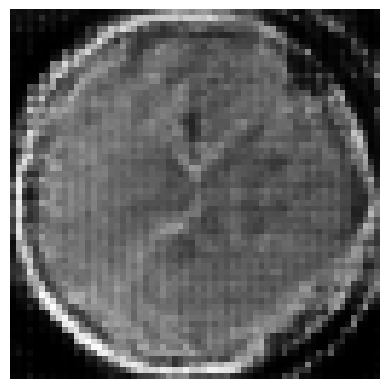

In [42]:
import numpy as np
import matplotlib.pyplot as plt

filename = "/Users/oscar/Desktop/Queens/Year 4/virtualEnvs/AGAN/AlphaGANMRI/predictions218.npy"
# Load the numpy file
img_array = np.load(filename, allow_pickle=True)

# Normalize the data to [0, 1]
img_array_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())

# Add the channel dimension back
img_array_normalized_with_channel = img_array_normalized[0, :, :, 0]

# Display the image
plt.imshow(img_array_normalized_with_channel, cmap="gray")
plt.axis('off')  # Turn off axis labels
plt.show()


In [ ]:
img = plt.imread("cleaned/Training/notumor/Tr-noTr_0000.jpg", format='jpg')
